In [1]:
#import section
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier,Pool
from IPython.display import display
import matplotlib.patches as patch
import matplotlib.pyplot as plt
from sklearn.svm import NuSVR
from scipy.stats import norm
import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import time
import glob
import sys
import os
import gc
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
fold_n=5
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)
%matplotlib inline
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 15)

In [3]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
sample_submission = pd.read_csv("./sample_submission.csv")

In [4]:
sample_submission.head()

,ID_code,target
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


In [5]:
train.shape, test.shape, sample_submission.shape

((200000, 202), (200000, 201), (200000, 2))

In [6]:
# reducing memory
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :", start_mem_usg, "MB")
    NAlist = [] # NULL대신 값을 채워 넣은 컬럼을 저장해둠
    for col in df.columns:
        if df[col].dtype != object: #카테고리형 데이터가 아니라면 (숫자형)

            # 현재 컬럼의 타입 출력
            print("****************")
            print("Column: ", col)
            print("dtype defore: ", df[col].dtype)

            # max와 int를 계산해둠 isInt는 아래 조건을 만족하는지 체크하기 위한 플래그
            isInt = False
            mx = df[col].max()
            mn = df[col].min()

            # 아래의 작업들을 위해서 빈 값들을 채워둠
            if not np.isfinite(df[col]).all():
                NAlist.append(col)
                df[col].fillna(mn-1, inplace=True)

            # int라면 값이 asint한 값과 같을 것이므로 result는 0일것이다 -> int 판별
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                isInt = True

            if isInt :
                if mn >= 0:
                    if mx < 255 :
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535 :
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295 :
                        df[col] = df[col].astype(np.uint32)
                    else :
                        df[col] = df[col].astype(np.uint64)
                else :
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max :
                        df[col] = df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max :
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max :
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int62).min and mx < np.iinfo(np.int64).max :
                        df[col] = df[col].astype(np.int64)
            else :
                df[col] = df[col].astype(np.float32)

            print("dtype after: ", df[col].dtype)
            print("*****************************")

    print("__MEMORY USAGE AFTER FOMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage is: ", mem_usg, " MB")
    print("This is ", 100*mem_usg/start_mem_usg, "% of the initial size")
    return df, NAlist

In [7]:
train, NAlist = reduce_mem_usage(train)

Memory usage of properties dataframe is : 308.2276611328125 MB
****************
Column:  target
dtype defore:  int64
dtype after:  uint8
*****************************
****************
Column:  var_0
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_1
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_2
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_3
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_4
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_5
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_6
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_7
dtype defore:  float64
dtype after:  float32
*******

dtype after:  float32
*****************************
****************
Column:  var_77
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_78
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_79
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_80
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_81
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_82
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_83
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_84
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_85
dtype defore:  float64
dtype after:  float32
******

dtype after:  float32
*****************************
****************
Column:  var_153
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_154
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_155
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_156
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_157
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_158
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_159
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_160
dtype defore:  float64
dtype after:  float32
*****************************
****************
Column:  var_161
dtype defore:  float64
dtype after:  float

In [8]:
print(NAlist)

[]


In [9]:
train.columns

Index(['ID_code', 'target', 'var_0', 'var_1', 'var_2', 'var_3', 'var_4',
       'var_5', 'var_6', 'var_7',
       ...
       'var_190', 'var_191', 'var_192', 'var_193', 'var_194', 'var_195',
       'var_196', 'var_197', 'var_198', 'var_199'],
      dtype='object', length=202)

In [10]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float32(200), object(1), uint8(1)
memory usage: 154.3+ MB
None


In [11]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,...,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000,200000.000000000000000
mean,0.100490000000000,10.679972648620605,-1.627627611160278,10.715126037597656,6.796522617340088,11.078254699707031,-5.065340042114258,5.408960819244385,16.545988082885742,0.284159243106842,...,3.234436273574829,7.438448905944824,1.927832603454590,3.331773042678833,17.993810653686523,-0.142086714506149,2.303354501724243,8.908224105834961,15.870863914489746,-3.326541900634766
std,0.300652975806093,3.039989709854126,4.049966812133789,2.640832424163818,2.043276309967041,1.623113632202148,7.863115310668945,0.866584956645966,3.418008565902710,3.332575798034668,...,4.559854030609131,3.023208379745483,1.478387713432312,3.991934061050415,3.135113477706909,1.429340600967407,5.454273700714111,0.921603024005890,3.010892391204834,10.437831878662109
min,0.000000000000000,0.408399999141693,-15.043399810791016,2.117100000381470,-0.040199998766184,5.074800014495850,-32.562599182128906,2.347300052642822,5.349699974060059,-10.505499839782715,...,-14.093299865722656,-2.691699981689453,-3.814500093460083,-11.783399581909180,8.694399833679199,-5.261000156402588,-14.209600448608398,5.960599899291992,6.299300193786621,-38.852798461914062
25%,0.000000000000000,8.453850269317627,-4.740024805068970,8.722474813461304,5.254074931144714,9.883174657821655,-11.200350046157837,4.767700195312500,13.943799972534180,-2.317800045013428,...,-0.058825000189245,5.157400131225586,0.889775007963181,0.584599971771240,15.629799842834473,-1.170699954032898,-1.946925014257431,8.252799987792969,13.829700469970703,-11.208474636077881
50%,0.000000000000000,10.524750232696533,-1.608050048351288,10.579999923706055,6.824999809265137,11.108250141143799,-4.833149909973145,5.385099887847900,16.456800460815430,0.393700003623962,...,3.203599929809570,7.347749948501587,1.901299953460693,3.396350026130676,17.957949638366699,-0.172700002789497,2.408900022506714,8.888199806213379,15.934050083160400,-2.819550037384033
75%,0.000000000000000,12.758199691772461,1.358625024557114,12.516699790954590,8.324099540710449,12.261124849319458,0.924799978733063,6.002999782562256,19.102899551391602,2.937900066375732,...,6.406199932098389,9.512524843215942,2.949500083923340,6.205800056457520,20.396524906158447,0.829599976539612,6.556725144386292,9.593299865722656,18.064724445343018,4.836800098419189
max,1.000000000000000,20.315000534057617,10.376799583435059,19.353000640869141,13.188300132751465,16.671400070190430,17.251600265502930,8.447699546813965,27.691799163818359,10.151300430297852,...,18.440900802612305,16.716499328613281,8.402400016784668,18.281799316406250,27.928800582885742,4.272900104522705,18.321500778198242,12.000399589538574,26.079099655151367,28.500699996948242


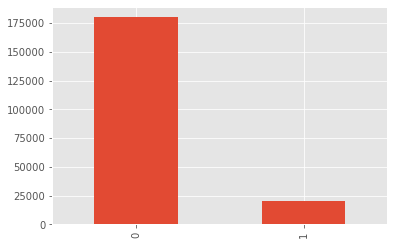

In [12]:
train['target'].value_counts().plot.bar();

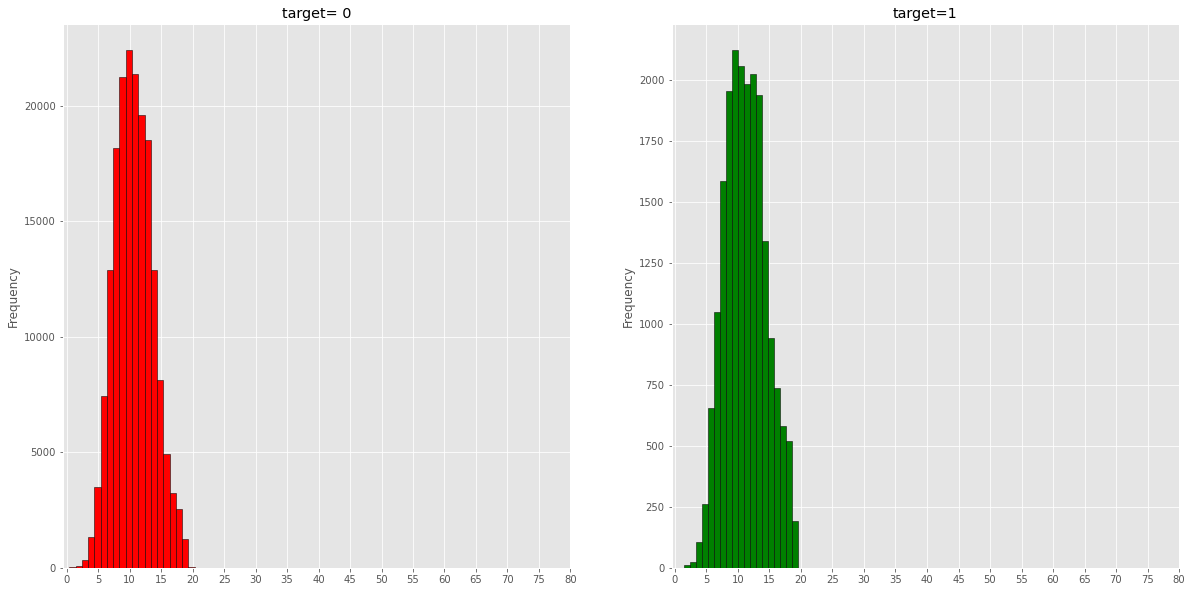

In [13]:
f, ax=plt.subplots(1,2,figsize=(20,10))
train[train['target']==0].var_0.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('target= 0')
x1=list(range(0,85,5))
ax[0].set_xticks(x1)
train[train['target']==1].var_0.plot.hist(ax=ax[1], color='green', bins=20, edgecolor='black')
ax[1].set_title('target=1')
x2=list(range(0,85,5))
ax[1].set_xticks(x2)
plt.show()

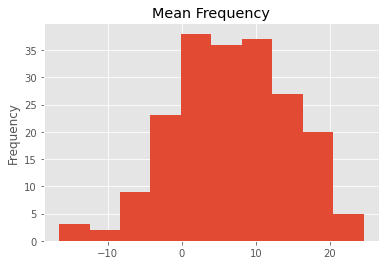

In [14]:
train[train.columns[2:]].mean().plot(kind='hist');
plt.title('Mean Frequency');

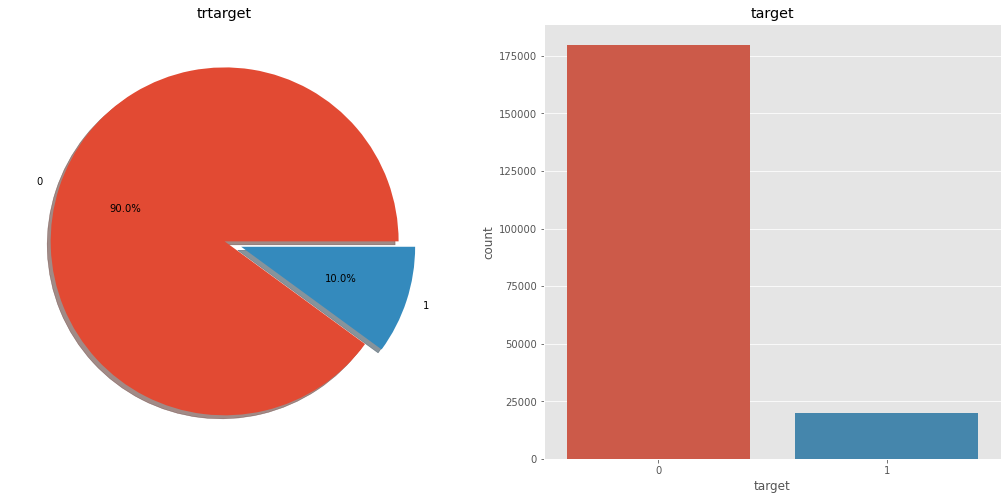

In [15]:
f, ax = plt.subplots(1,2,figsize=(18,8))
train['target'].value_counts().plot.pie(explode=[0,0.1], autopct = '%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('trtarget')
ax[0].set_ylabel('')
sns.countplot('target', data=train, ax=ax[1])
ax[1].set_title('target')
plt.show()

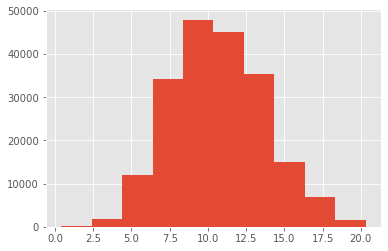

In [16]:
train["var_0"].hist();

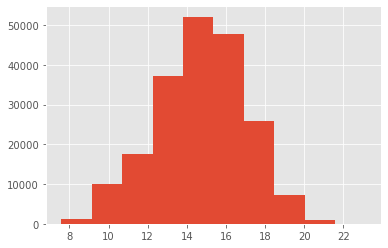

In [17]:
train["var_81"].hist();

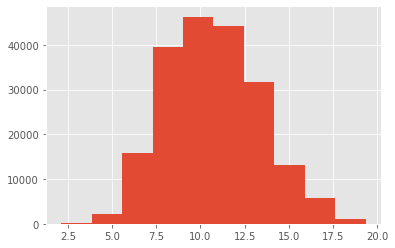

In [18]:
train["var_2"].hist();


In [19]:
sns.set(rc={'figure.figsize':(9,7)})

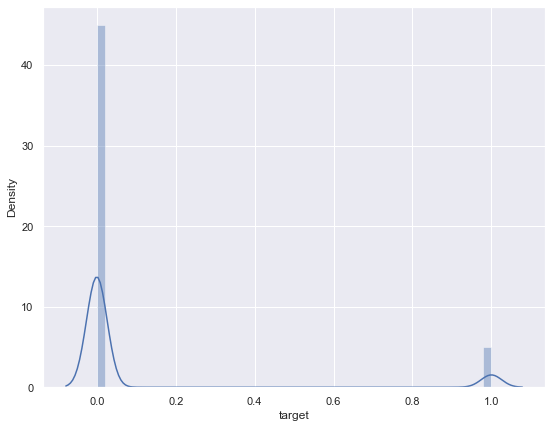

In [20]:
sns.distplot(train['target']);

<AxesSubplot:xlabel='target', ylabel='var_0'>

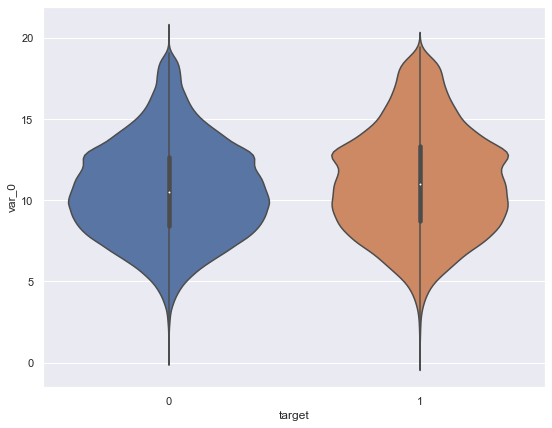

In [21]:
sns.violinplot(data=train, x="target", y="var_0")

<AxesSubplot:xlabel='target', ylabel='var_81'>

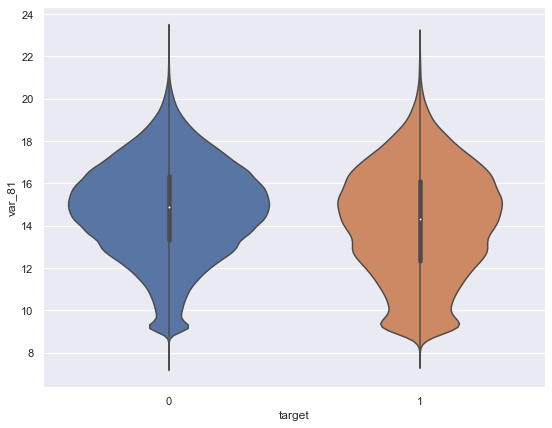

In [22]:
sns.violinplot(data=train, x="target", y="var_81")

In [23]:
def check_missing_data(df):
    flag = df.isna().sum().any()
    if flag == True:
        # NULL이 하나라도 있다면 OUTPUT에 Total, Percent, data type를 리턴
        total = df.isnull().sum()
        percent = (df.isnull().sum()) / (df.isnull().count()*100)
        output = pd.concat([total, percent], axis=1, keys=['Total', Percent])
        data_type = []
        
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else :
        return(False)

In [24]:
check_missing_data(train)

False

In [25]:
check_missing_data(test)

False

In [26]:
train['target'].unique()

array([0, 1], dtype=uint8)

In [27]:
train['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [28]:
def check_balance(df, target):
    check=[]
    
    print('size of data is : ', df.shape[0])
    for i in [0,1]:
        print('for target {} = '.format(i))
        print(df[target].value_counts()[i]/df.shape[0]*100, '%')

In [44]:
check_balance(train,'target')

size of data is :  200000
for target 0 = 
89.95100000000001 %
for target 1 = 
10.049 %


In [45]:
print("Skewness: %f"%train['target'].skew())
print("Kurtosis: %f"%train['target'].kurt())

Skewness: 2.657642
Kurtosis: 5.063112


In [31]:
print("-------------------")

-------------------


In [32]:
cols=["target", "ID_code"]
X = train.drop(cols, axis=1)
y = train["target"]

In [33]:
X_test = test.drop("ID_code", axis=1)

In [35]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
rfc_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [36]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

In [37]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=150)

Weight,Feature
0.0000 ± 0.0000,var_99
0.0000 ± 0.0000,var_184
0.0000 ± 0.0000,var_174
0.0000 ± 0.0000,var_166
0.0000 ± 0.0000,var_154
0.0000 ± 0.0000,var_12
0.0000 ± 0.0000,var_133
0.0000 ± 0.0000,var_145
0.0000 ± 0.0000,var_140
0.0000 ± 0.0000,var_139


In [38]:
train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=1)
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

In [39]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]

In [40]:
from sklearn import tree
import graphviz
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)

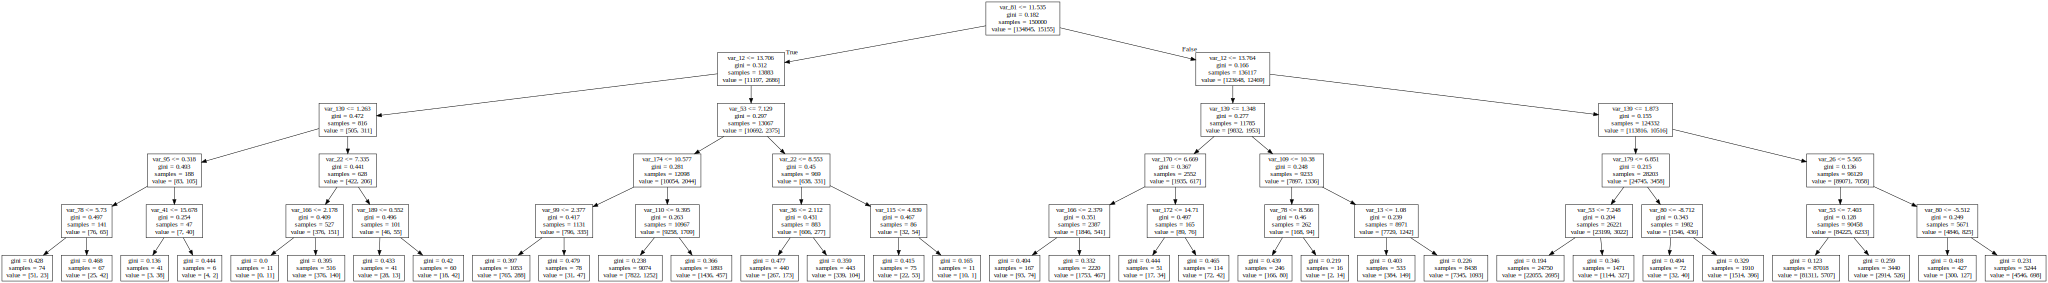

In [41]:
graphviz.Source(tree_graph)

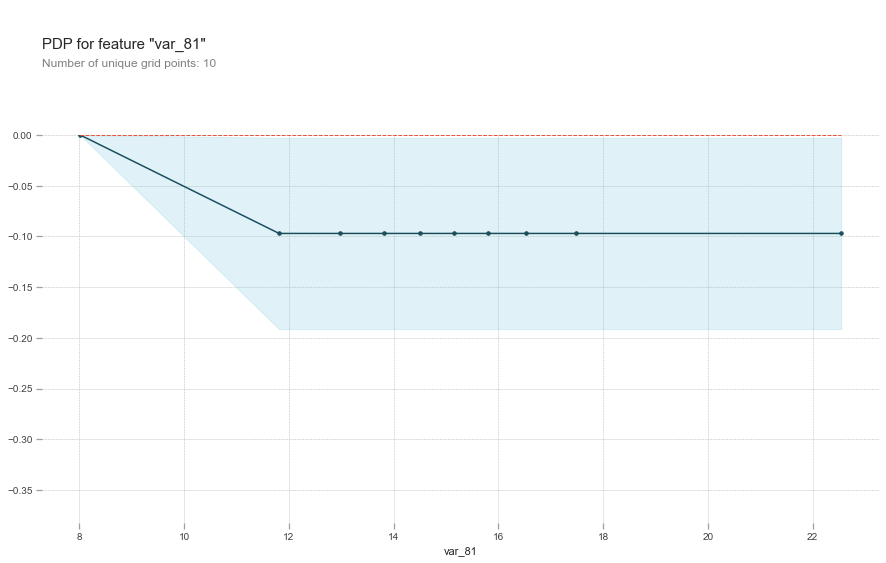

In [47]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_81')

pdp.pdp_plot(pdp_goals, 'var_81')
plt.show()

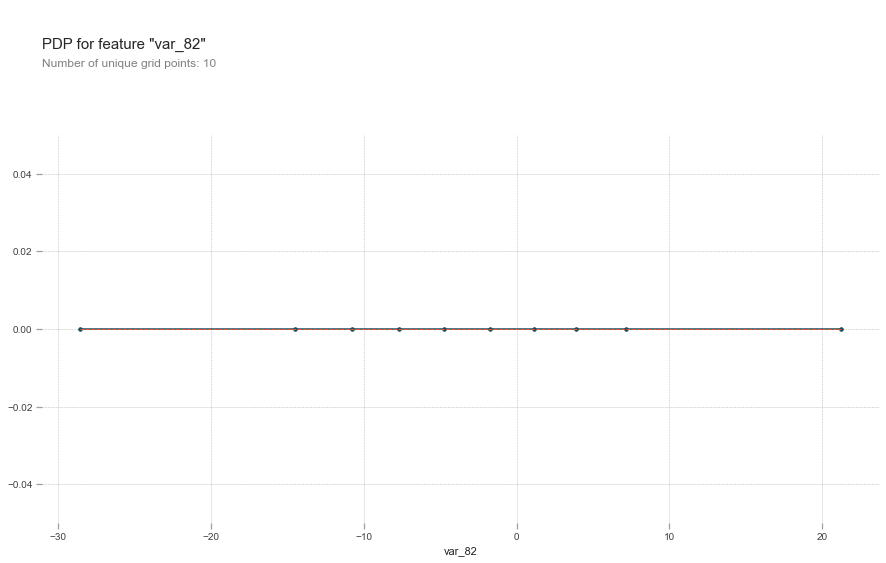

In [48]:
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_82')

pdp.pdp_plot(pdp_goals, 'var_82')
plt.show()

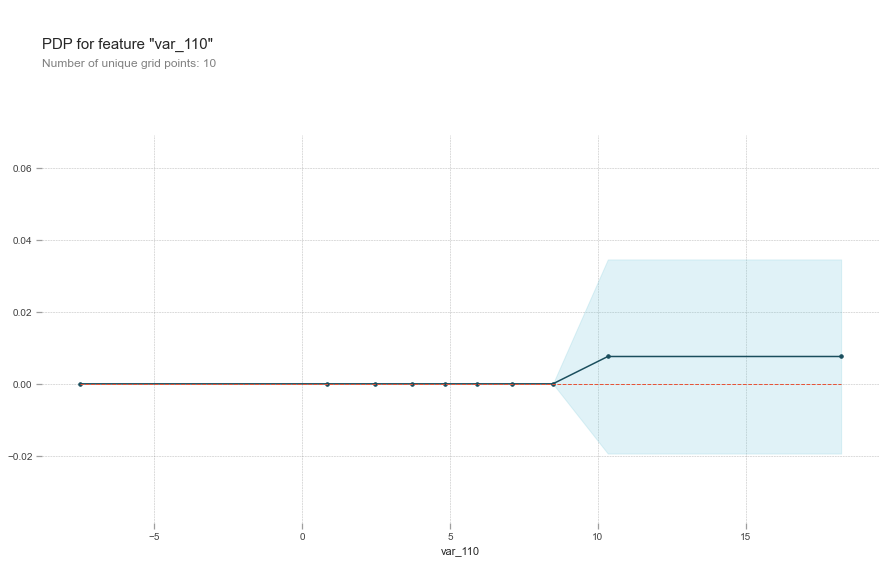

In [49]:
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=features, feature='var_110')

pdp.pdp_plot(pdp_goals, 'var_110')
plt.show()

In [76]:
params = {'objective' : "binary", 
               'boost':"gbdt",
               'metric':"auc",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.01,
               'num_leaves' : 13,
               'max_depth':-1,
               'tree_learner' : "serial",
               'feature_fraction' : 0.05,
               'bagging_freq' : 5,
               'bagging_fraction' : 0.4,
               'min_data_in_leaf' : 80,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : 1}

In [80]:
%%time
y_pred_lgd = np.zeros(len(X_test))
num_round = 1000000
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    lgb_model = lgb.train(params, train_data, num_round, valid_sets = [train_data, valid_data], verbose_eval=1000, early_stopping_rounds = 3500)
    
    y_pred_lgb += lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)/5

Fold 0 started at Tue Mar 30 18:57:11 2021
[LightGBM] [Info] Number of positive: 16079, number of negative: 143921
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51000
[LightGBM] [Info] Number of data points in the train set: 160000, number of used features: 200
Training until validation scores don't improve for 3500 rounds
[1000]	training's auc: 0.891002	valid_1's auc: 0.869777
[2000]	training's auc: 0.907644	valid_1's auc: 0.882938
[3000]	training's auc: 0.918572	valid_1's auc: 0.890365
[4000]	training's auc: 0.925918	valid_1's auc: 0.893819
[5000]	training's auc: 0.931772	valid_1's auc: 0.896351
[6000]	training's auc: 0.936865	valid_1's auc: 0.897795
[7000]	training's auc: 0.941366	valid_1's auc: 0.898606
[8000]	training's auc: 0.945427	valid_1's auc: 0.898867
[9000]	training's auc: 0.949252	valid_1's auc: 0.89921
[10000]	training's auc: 

NameError: name 'y_pred_lgb' is not defined

In [81]:
y_pred_rfc = rfc_model.predict(X_test)

In [82]:
y_pred_tree = tree_model.predict(X_test)

In [83]:
train_pool = Pool(train_X,train_y)
cat_model = CatBoostClassifier(iterations = 3000, learning_rate=0.03, objective="Logloss", eval_metric='AUC')
cat_model.fit(train_X, train_y, silent=True)
y_pred_cat = cat_model.predict(X_test)